In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors 

### Data Cleaning

In [6]:
df_airbnb = pd.read_csv('../../data/Airbnb_Open_Data.csv')

/var/folders/5v/s327w09x2b7bc679clc46r0h0000gq/T/ipykernel_31532/3947172217.py:1: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  df_airbnb = pd.read_csv('../../data/Airbnb_Open_Data.csv')


In [7]:
# drop the column we do not use
df_airbnb = df_airbnb.drop(['id', 'host id','country','country code','license','last review'], axis=1)

# change host_identity_verified to binary int
df_airbnb['host_identity_verified'] = df_airbnb['host_identity_verified'].map({'verified': 1, 'unconfirmed': 0})

# combine the same group for neighbourhood group
df_airbnb['neighbourhood group'] = df_airbnb['neighbourhood group'].replace('brookln', 'Brooklyn').replace('manhatan', 'Manhattan')

# Fill missing values in the 'neighbourhood group' column with a placeholder (e.g., 'Unknown')
df_airbnb['neighbourhood group'].fillna('Unknown', inplace=True)
df_airbnb['neighbourhood'].fillna('Unknown', inplace=True)

# Apply the function to fill missing prices
df_airbnb['price'] = df_airbnb['price'].replace('[\$,]', '', regex=True)
df_airbnb['service fee'] = df_airbnb['service fee'].replace('[\$,]', '', regex=True)

# Convert the "price" column to a float data type
df_airbnb['price'] = df_airbnb['price'].astype(float)
df_airbnb['service fee'] = df_airbnb['service fee'].astype(float)

# Calculate the average price for each neighborhood
average_prices = df_airbnb.groupby('neighbourhood')['price'].mean()

# Function to fill missing prices with the average price of the neighborhood
def fill_missing_price(row):
    if pd.isnull(row['price']):
        return average_prices[row['neighbourhood']]
    else:
        return row['price']

# Apply the function to update missing prices
df_airbnb['price'] = df_airbnb.apply(fill_missing_price, axis=1)

#Apply latitude and longitude restrictions for NYC
df_airbnb = df_airbnb[(df_airbnb['lat']>40.55) &(df_airbnb['lat']<40.94) & (df_airbnb['long']>-74.1) & (df_airbnb['long']<-73.67)]

#Deal with Strings: 
def df_normalize_strings(df, col):
    df[col] = df[col].str.lower() # change everything to lower cases
    df[col] = df[col].fillna(np.nan) # make None -> np.nan
    df[col] = df[col].replace('none or unspecified', np.nan)
    df[col] = df[col].replace('none', np.nan)
    df[col] = df[col].replace('no', np.nan)
    df[col] = df[col].replace('#name?', np.nan)
    df[col] = df[col].replace('', np.nan) # empty -> NaN

df_airbnb['NAME'] = df_airbnb['NAME'].astype(str)
df_airbnb['house_rules'] = df_airbnb['house_rules'].astype(str)
df_normalize_strings(df_airbnb, 'NAME')
df_normalize_strings(df_airbnb, 'house_rules')

#Change to catgorical 
def df_to_categorical(df, col):
    df[col] = df[col].astype('category')

df_to_categorical(df_airbnb, 'neighbourhood group')
df_to_categorical(df_airbnb, 'neighbourhood')
df_to_categorical(df_airbnb, 'instant_bookable')
df_to_categorical(df_airbnb, 'cancellation_policy')
df_to_categorical(df_airbnb, 'room type')

In [8]:
df_airbnb.describe()

,host_identity_verified,lat,long,Construction year,price,service fee,minimum nights,number of reviews,reviews per month,review rate number,calculated host listings count,availability 365
count,101928.000000,102216.000000,102216.000000,102003.000000,102216.000000,101945.000000,101808.000000,102033.000000,86387.000000,101890.000000,101897.000000,101768.000000
mean,0.499588,40.728577,-73.948946,2012.491858,625.444538,125.057296,8.140647,27.474082,1.373247,3.279036,7.958409,140.944629
std,0.500002,0.055336,0.048214,5.765023,331.295135,66.330754,30.596261,49.538938,1.747455,1.284741,32.277100,135.404574
min,0.000000,40.565460,-74.099840,2003.000000,50.000000,10.000000,-1223.000000,0.000000,0.010000,1.000000,1.000000,-10.000000
25%,0.000000,40.688990,-73.982340,2008.000000,341.000000,68.000000,2.000000,1.000000,0.220000,2.000000,1.000000,3.000000
50%,0.000000,40.722530,-73.954330,2012.000000,625.000000,125.000000,3.000000,7.000000,0.740000,3.000000,1.000000,96.000000
75%,1.000000,40.762890,-73.932228,2018.000000,912.000000,183.000000,5.000000,30.000000,2.000000,4.000000,2.000000,268.000000
max,1.000000,40.916970,-73.705220,2022.000000,1200.000000,240.000000,5645.000000,1024.000000,90.000000,5.000000,332.000000,3677.000000


In [9]:
df_airbnb['review rate number'].value_counts()

5.0    23275
4.0    23254
3.0    23178
2.0    22993
1.0     9190
Name: review rate number, dtype: int64

In [10]:
df_airbnb['minimum nights'].value_counts()

 1.0      25328
 2.0      23467
 3.0      16067
 30.0     11616
 4.0       6609
          ...  
-3.0          1
 273.0        1
 149.0        1
 175.0        1
 825.0        1
Name: minimum nights, Length: 153, dtype: int64

In [11]:
df_airbnb['minimum nights'].quantile([0,0.01,0.1,0.25,0.5,0.75,0.9,0.99,1])

0.00   -1223.00
0.01       1.00
0.10       1.00
0.25       2.00
0.50       3.00
0.75       5.00
0.90      30.00
0.99      52.79
1.00    5645.00
Name: minimum nights, dtype: float64

In [12]:
df_airbnb['price'].quantile([0,0.01,0.1,0.25,0.5,0.75,0.9,0.99,1])

0.00      50.0
0.01      61.0
0.10     165.0
0.25     341.0
0.50     625.0
0.75     912.0
0.90    1085.0
0.99    1188.0
1.00    1200.0
Name: price, dtype: float64

In [13]:
df_airbnb['reviews per month'].quantile([0,0.01,0.1,0.25,0.5,0.75,0.9,0.99,1])

0.00     0.01
0.01     0.02
0.10     0.08
0.25     0.22
0.50     0.74
0.75     2.00
0.90     3.54
0.99     7.07
1.00    90.00
Name: reviews per month, dtype: float64

In [14]:
#replace negative minimum nights with zero 
df_airbnb[df_airbnb['minimum nights'] == -1223]
df_airbnb.loc[42446,'minimum nights'] = 0
df_airbnb.loc[42446,'minimum nights']

0.0

In [15]:
# Replace reviews per month > 30 with median 
m = df_airbnb['reviews per month'].median()
df_airbnb[df_airbnb['reviews per month'] == 90]
df_airbnb.loc[49653,'reviews per month'] = m

df_airbnb[df_airbnb['reviews per month'] == 44.63]
df_airbnb.loc[53144,'reviews per month'] = m

df_airbnb[df_airbnb['reviews per month'] == 33.08]
df_airbnb.loc[62244,'reviews per month'] = m


In [16]:
print('price')
print(f"mean: {df_airbnb['price'].mean()}")
print(f"median: {df_airbnb['price'].median()}")
print('\nreview rate')
print(f"mean: {df_airbnb['review rate number'].mean()}")
print(f"median: {df_airbnb['review rate number'].median()}")
print('\nreviews per month')
print(f"mean: {df_airbnb['reviews per month'].mean()}")
print(f"median: {df_airbnb['reviews per month'].median()}")

price
mean: 625.4445383870735
median: 625.0

review rate
mean: 3.2790362155265482
median: 3.0

reviews per month
mean: 1.3713315660921201
median: 0.74


## Data Visualization

### Word Cloud

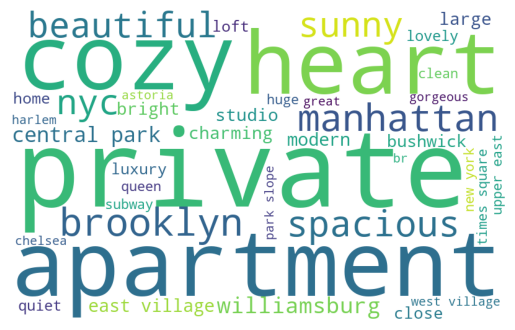

In [17]:
# First, strip to remove the space from the beginning and end, then normalize the text to be lowercase
df_airbnb['NAME'] = df_airbnb['NAME'].str.strip().str.lower()

# Now combine the strings from all rows in that column, separating them by space
text = df_airbnb['NAME'].str.cat(sep=' ')

stop_words = ['in', 'the', 'to', '1', 'with', '2', 'of', '&', 'and', '-', 'a', 'from', 'apt', 'min', 'room', 'bedroom', 'bed', 'one', '1br', 'for', 'w/', 'side']

from wordcloud import WordCloud
wordcloud = WordCloud(background_color='white', stopwords=stop_words,
                      width=800, height=500, max_words=40) #colormap="PuBuGn", 
wordcloud.generate(text)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### Adjectives in title Count

In [18]:
name_words = []
for row in df_airbnb['NAME']:
    row = str(row)
    words = row.split()
    for word in words:
        name_words.append(word)

name_words = np.array(name_words)
df = pd.DataFrame(name_words, columns =['words'])
value_counts = df['words'].value_counts(dropna=True, sort=True)


<BarContainer object of 30 artists>

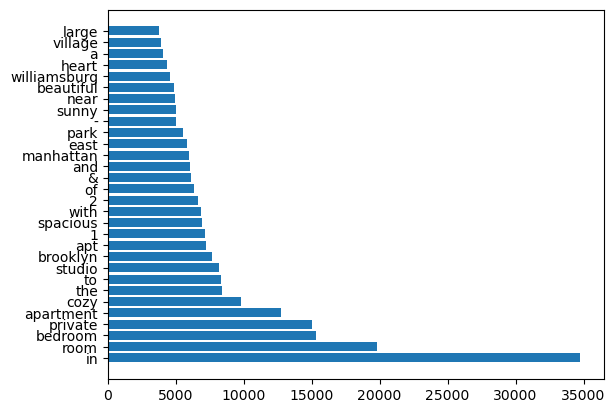

In [19]:
x = value_counts[:30].index
y = value_counts[:30].values
fig, ax = plt.subplots()
ax.barh(x, y)

In [20]:
restricted = value_counts.copy()
restricted[:30]
restricted_words = ['home', 'loft', 'brooklyn', 'manhattan', 'park', 'near', 'nyc', 'williamsburg', 
                    'heart', 'village', 'east', 'in', 'the', 'to', '1', 'with', '2', 'of', '&', 'and', 
                    '-', 'a', 'from', 'apt', 'min', 'room', 'bedroom', 'bed', 'one', '1br', 'for', 'w/', 
                    'side', 'apartment', 'studio']
restricted = restricted.drop(restricted_words)
restricted[:30]

private       15051
cozy           9767
spacious       6902
sunny          4984
beautiful      4874
large          3753
modern         3560
central        3545
luxury         3308
new            3164
west           3017
bright         2787
charming       2608
upper          2581
midtown        2459
brownstone     2366
great          2270
location       2268
bushwick       2264
close          2248
on             2222
quiet          2134
br             2113
3              2034
harlem         2026
|              1963
+              1898
garden         1877
huge           1795
by             1759
Name: words, dtype: int64

Make popular words in name a word map/word bubble. 
Then maybe do a avg rating per word? 

<BarContainer object of 30 artists>

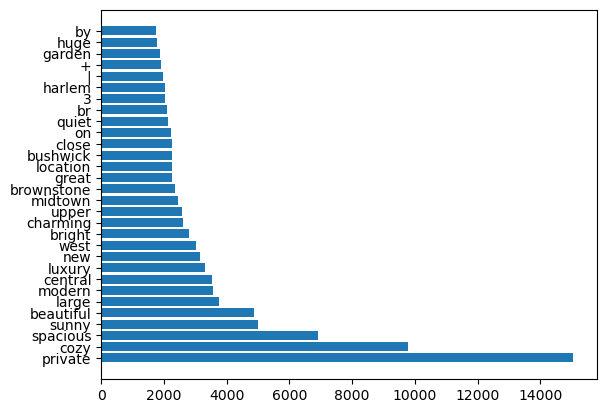

In [21]:
x = restricted[:30].index
y = restricted[:30].values
fig, ax = plt.subplots()
ax.barh(x, y)

In [22]:
top10 = restricted[:10].sort_values(ascending=True)
top10



new           3164
luxury        3308
central       3545
modern        3560
large         3753
beautiful     4874
sunny         4984
spacious      6902
cozy          9767
private      15051
Name: words, dtype: int64

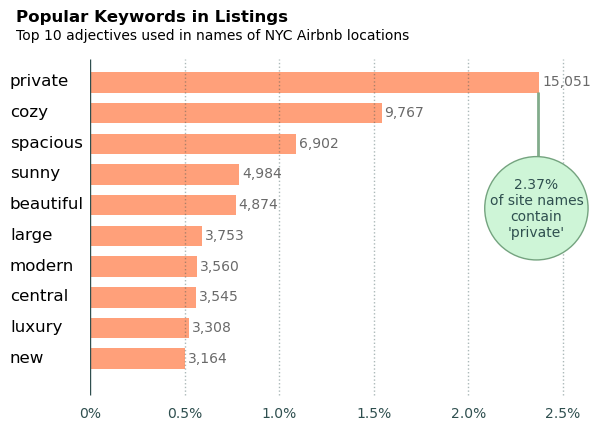

In [23]:
x = top10.index.values
y = top10.values

#Make Plot
fig, ax = plt.subplots()
ax.barh(x, y, height = 0.67, color='lightsalmon')

#Title
x_left = -2500
ax.text(x_left, 11, "Popular Keywords in Listings",fontsize=12, fontweight="bold")
ax.text(x_left, 10.4, "Top 10 adjectives used in names of NYC Airbnb locations",fontsize=10)

#Y axis
x_left = -2700
y_start = -.1
for i in range(len(x)):
    ax.text(x_left, y_start + i, f"{x[i]}" ,fontsize=12)

#hide frames
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
#ax.spines['left'].set_linewidth(.7)
#ax.spines['left'].set_color('gray')
ax.spines['bottom'].set_linewidth(False)
ax.set_xticks([])
ax.set_yticks([])

#add texts on right of bar (can be added in above)
for i, rect in enumerate(ax.patches):
    x = rect.get_width() + 100 # x-value of text
    y = y_start + i 
    label = f'{top10.values[i]:,d}' # | {(top10.values[i] / len(df) * 100):.02f}%'
    ax.annotate(label,(x, y),size=10,color='dimgrey')

#Add percents
p = 0.025
ax.vlines(x=len(df) * p,ymin=-1.2,ymax=9.75 ,color='darkslategray',linewidth=1 ,alpha=0.4, linestyles='dotted')
ax.text(len(df) * p, -2, "2.5%",fontsize=10, color ='darkslategray', verticalalignment = 'bottom', horizontalalignment='center')
p = 0.02
ax.vlines(x=len(df) * p,ymin=-1.2,ymax=9.75 ,color='darkslategray',linewidth=1 ,alpha=0.4, linestyles='dotted')
ax.text(len(df) * p, -2, "2.0%",fontsize=10, color ='darkslategray', verticalalignment = 'bottom', horizontalalignment='center')
p = 0.015
ax.vlines(x=len(df) * p,ymin=-1.2,ymax=9.75 ,color='darkslategray',linewidth=1 ,alpha=0.4, linestyles='dotted')
ax.text(len(df) * p, -2, "1.5%",fontsize=10, color ='darkslategray', verticalalignment = 'bottom', horizontalalignment='center')
p = 0.01
ax.vlines(x=len(df) * p,ymin=-1.2,ymax=9.75 ,color='darkslategray',linewidth=1 ,alpha=0.4, linestyles='dotted')
ax.text(len(df) * p, -2, "1.0%",fontsize=10, color ='darkslategray', verticalalignment = 'bottom', horizontalalignment='center')
p = 0.005
ax.vlines(x=len(df) * p,ymin=-1.2,ymax=9.75 ,color='darkslategray',linewidth=1 ,alpha=0.4, linestyles='dotted')
ax.text(len(df) * p, -2, "0.5%",fontsize=10, color ='darkslategray', verticalalignment = 'bottom', horizontalalignment='center')
p=0
ax.vlines(x=len(df) * p,ymin=-1.2,ymax=9.75 ,color='darkslategray',linewidth=1 ,alpha=1, linestyles='-')
ax.text(len(df) * p, -2, "0%",fontsize=10, color ='darkslategray', verticalalignment = 'bottom', horizontalalignment='center')

#Add text box
set1 = dict(facecolor='#cef5d7', edgecolor='#74a37f', boxstyle="circle")
ax.text((len(df) * 0.0236),4.9,"\n2.37%\nof site names\ncontain\n'private'\n", fontsize=10, color ='darkslategray',
        verticalalignment='center', horizontalalignment='center', bbox=set1)
ax.vlines(x=15000,ymin=5,ymax=8.7,color='#74a37f',linewidth=2,alpha=0.9)


#add background color
#ax.set_facecolor(color='#f7f4ed')
#fig.patch.set_facecolor('#f7f4ed')

plt.show()

### Adjectives in title effect on other variables

In [24]:
#Check if word in title - add columns 
df_airbnb_seneth = df_airbnb.copy()
top_words = top10.index.values
for word in top_words:
    df_airbnb_seneth[word] = df_airbnb_seneth['NAME'].str.contains(word)           
top_words

array(['new', 'luxury', 'central', 'modern', 'large', 'beautiful',
       'sunny', 'spacious', 'cozy', 'private'], dtype=object)

In [25]:
len(df_airbnb_seneth)

102216

In [26]:
df_airbnb_seneth['minimum nights'].value_counts()
df_airbnb_seneth.groupby('new').mean()['reviews per month']

/var/folders/5v/s327w09x2b7bc679clc46r0h0000gq/T/ipykernel_31532/1461786405.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_airbnb_seneth.groupby('new').mean()['reviews per month']


new
False    1.364394
True     1.524559
Name: reviews per month, dtype: float64

/var/folders/5v/s327w09x2b7bc679clc46r0h0000gq/T/ipykernel_31532/3747469877.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_rvm.groupby('new').mean()['reviews per month']
/var/folders/5v/s327w09x2b7bc679clc46r0h0000gq/T/ipykernel_31532/3747469877.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tab = df_rvm.groupby([word]).mean()['reviews per month']
/var/folders/5v/s327w09x2b7bc679clc46r0h0000gq/T/ipykernel_31532/3747469877.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_

Text(10, 1, '                   difference\n          \n      \n0.25')

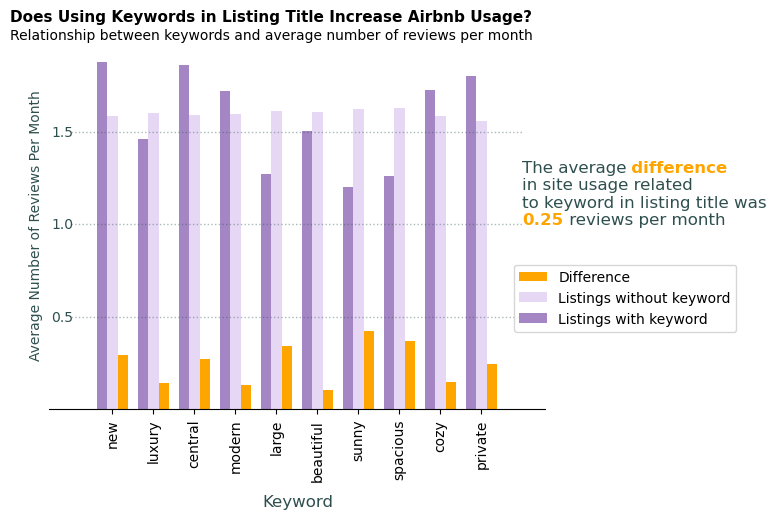

In [27]:
df_rvm = df_airbnb_seneth[df_airbnb_seneth['minimum nights'] <= 5].copy()
df_rvm.groupby('new').mean()['reviews per month']

avg_reviews_per_month = pd.DataFrame()

false = []
true = []
for word in top_words:  
    tab = df_rvm.groupby([word]).mean()['reviews per month']
    false.append(tab[0])
    true.append(tab[1])

avg_reviews_per_month['word'] = top_words
avg_reviews_per_month['false'] = np.array(false)
avg_reviews_per_month['true'] = np.array(true)
avg_reviews_per_month['difference'] = np.subtract(np.array(true),np.array(false))
avg_reviews_per_month['difference_p'] = np.where(avg_reviews_per_month['difference'] > 0, avg_reviews_per_month['difference'], 0)
avg_reviews_per_month['difference_n'] = np.where(avg_reviews_per_month['difference'] < 0, avg_reviews_per_month['difference'], 0)

avg_reviews_per_month['difference_a'] = np.where(avg_reviews_per_month['difference'] < 0, 0-avg_reviews_per_month['difference'], avg_reviews_per_month['difference'])

x = np.array(avg_reviews_per_month['word'])
y_f = np.array(avg_reviews_per_month['false'])
y_t = np.array(avg_reviews_per_month['true'])
y_da = np.array(avg_reviews_per_month['difference_a'])
y_dp = np.array(avg_reviews_per_month['difference_p'])
y_dn = np.array(avg_reviews_per_month['difference_n'])

#MakePlot
fig, ax = plt.subplots()
w = .25
ax.bar(np.arange(len(x))+w, y_da,  width=w, label="Difference", color = 'orange')
ax.bar(np.arange(len(x)), y_f,  width=w, label="Listings without keyword", color = '#e6d7f5')
ax.bar(np.arange(len(x))-(w), y_t,  width=w, label="Listings with keyword", color ='#a586c4')


#hide frames
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)


#yaxis
ax.hlines(y=0.5,xmin=-1, xmax=10 ,color='darkslategray',linewidth=1 ,alpha=0.4, linestyles='dotted')
ax.text(-1.5, 0.5, "0.5",fontsize=10, color ='darkslategray', verticalalignment = 'center', horizontalalignment='left')
ax.hlines(y=1,xmin=-1, xmax=10 ,color='darkslategray',linewidth=1 ,alpha=0.4, linestyles='dotted')
ax.text(-1.5, 1.0, "1.0",fontsize=10, color ='darkslategray', verticalalignment = 'center', horizontalalignment='left')
ax.hlines(y=1.5,xmin=-1, xmax=10 ,color='darkslategray',linewidth=1 ,alpha=0.4, linestyles='dotted')
ax.text(-1.5, 1.5, "1.5",fontsize=10, color ='darkslategray', verticalalignment = 'center', horizontalalignment='left')

ax.set_ylabel('Average Number of Reviews Per Month', color='darkslategray')
ax.set_yticks([])
ax.set_ylim(0,2)

#x-axis
ax.set_xticks(range(len(x)))
ax.set_xticklabels((word for word in x), rotation=90)
ax.text(3.65, -0.5, "Keyword",fontsize=12, color ='darkslategray', verticalalignment = 'center')

#title
x_left = -2.5
ax.text(x_left, 2.1, "Does Using Keywords in Listing Title Increase Airbnb Usage? ",fontsize=11, fontweight="bold")
ax.text(x_left, 2.0, "Relationship between keywords and average number of reviews per month",fontsize=10)

#legend
ax.legend(loc='center right', bbox_to_anchor=(1.4, 0.3))

#Added Text 
ax.text(s="The average\nin site usage related\nto keyword in listing title was\n         reviews per month", x=10, y=1, fontsize=12, color='darkslategray')
ax.text(s="                   difference\n          \n      \n0.25", x=10, y=1, fontsize=12, color='orange', fontweight='bold')

In [28]:
np.mean(y_da)

0.24513792488829234

In [29]:
df_airbnb_seneth['price'].quantile([0, 0.01,0.1,0.25,0.5,0.75,0.9,0.99,1])

0.00      50.0
0.01      61.0
0.10     165.0
0.25     341.0
0.50     625.0
0.75     912.0
0.90    1085.0
0.99    1188.0
1.00    1200.0
Name: price, dtype: float64

/var/folders/5v/s327w09x2b7bc679clc46r0h0000gq/T/ipykernel_31532/3274589221.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tab = df_airbnb_seneth.groupby([word]).mean()['price']
/var/folders/5v/s327w09x2b7bc679clc46r0h0000gq/T/ipykernel_31532/3274589221.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tab = df_airbnb_seneth.groupby([word]).mean()['price']
/var/folders/5v/s327w09x2b7bc679clc46r0h0000gq/T/ipykernel_31532/3274589221.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numer

/var/folders/5v/s327w09x2b7bc679clc46r0h0000gq/T/ipykernel_31532/3274589221.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tab = df_airbnb_seneth.groupby([word]).mean()['price']
/var/folders/5v/s327w09x2b7bc679clc46r0h0000gq/T/ipykernel_31532/3274589221.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tab = df_airbnb_seneth.groupby([word]).mean()['price']
/var/folders/5v/s327w09x2b7bc679clc46r0h0000gq/T/ipykernel_31532/3274589221.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numer

Text(10, 150, "                 \n                    \n                            \n'luxury'                \n             ")

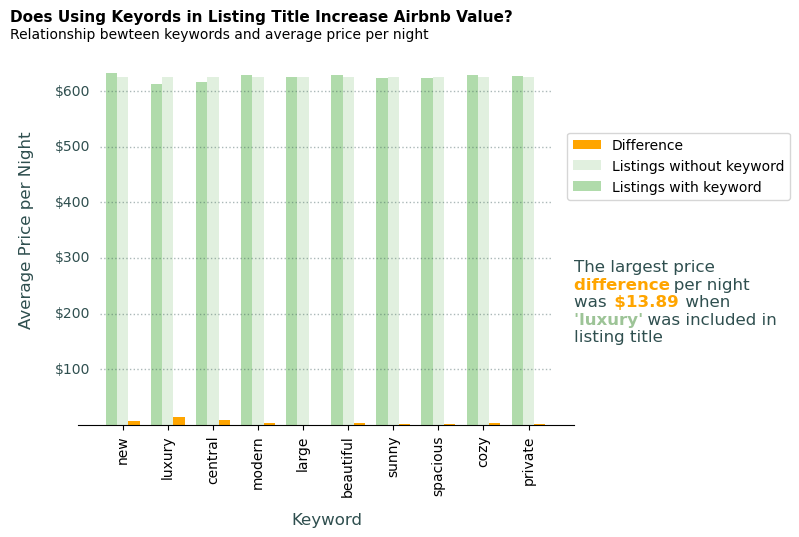

In [30]:
avg_price = pd.DataFrame()

false = []
true = []
for word in top_words:  
    tab = df_airbnb_seneth.groupby([word]).mean()['price']
    false.append(tab[0])
    true.append(tab[1])

avg_price['word'] = top_words
avg_price['false'] = np.array(false)
avg_price['true'] = np.array(true)
avg_price['difference'] = np.abs(np.subtract(np.array(true),np.array(false)))

x = np.array(avg_price['word'])
y_f = np.array(avg_price['false'])
y_t = np.array(avg_price['true'])
y_d = np.array(avg_price['difference'])

#Plot
fig, ax = plt.subplots()
w = .25
ax.bar(np.arange(len(x))+w, y_d,  width=w, label="Difference", color = 'orange')
ax.bar(np.arange(len(x)), y_f,  width=w, label="Listings without keyword", color = '#e1f0df')
ax.bar(np.arange(len(x))-w, y_t,  width=w, label="Listings with keyword", color = '#b0dbab') ##85bd7e

#x-axis
ax.set_xticks(range(len(x)))
ax.set_xticklabels((word for word in x), rotation=90)
ax.text(3.75, -170, "Keyword",fontsize=12, color ='darkslategray', verticalalignment = 'center')


#yaxis
for i in range(1,7):
    ax.hlines(y=100*i,xmin=-.5, xmax=9.5 ,color='darkslategray',linewidth=1 ,alpha=0.4, linestyles='dotted')
    ax.text(-1.5, (100*i), f'${100*i}',fontsize=10, color ='darkslategray', verticalalignment = 'center')
ax.text(-2.3, 350, "Average Price per Night",fontsize=12, color ='darkslategray', verticalalignment = 'center', rotation=90)


#hide frames
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_yticks([])
#ax.spines['bottom'].set_linewidth(False)

#title
x_left = -2.5
ax.text(x_left, 725, "Does Using Keyords in Listing Title Increase Airbnb Value? ",fontsize=11, fontweight="bold")
ax.text(x_left, 695, "Relationship bewteen keywords and average price per night",fontsize=10)

#Legend
ax.legend(loc='center right', bbox_to_anchor=(1.45, 0.7))

#Added Text 
ax.text(s="The largest price\n                   per night\nwas               when      \n              was included in \nlisting title", x=10, y=150, fontsize=12, color='darkslategray')
ax.text(s="                 \ndifference          \n       $13.89            \n                \n             ", x=10, y=150, fontsize=12, color='orange', fontweight='bold')
ax.text(s="                 \n                    \n                            \n'luxury'                \n             ", x=10, y=150, fontsize=12, color='#9dc497', fontweight='bold')